- I will use this scratch notebook to help infill ensemble members for LGMR
- i only want to do this using the annual mean values

In [2]:
#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd
import datetime

import pykrige.ok as pyok
from sklearn.metrics.pairwise import haversine_distances

import datetime
begin_time = datetime.datetime.now()

In [2]:
## ensemble member version
## this will determine name of what is saved

path = '/home/disk/sipn/vcooper/nobackup/lgm/LGMR/'
fname = 'LGMR_SST_holo_0-4ka_members.nc'
ds_holo_sst_all = xr.open_dataset(path + fname).sst_ann

fname = 'LGMR_SST_lgm_19-23ka_members.nc'
ds_lgm_sst_all = xr.open_dataset(path + fname).sst_ann


## BEGIN FOR LOOP
# for i in range(len(ds_holo_sst_all.nEns.values)):
iens=0
memstring = str(iens+1).zfill(2)

ds_holo_sst = ds_holo_sst_all.isel(nEns=iens)
ds_lgm_sst = ds_lgm_sst_all.isel(nEns=iens)

setname = 'LGMR_SST_holo_member' + memstring
ds_usingthis = ds_holo_sst ## choose whether to do holo or lgm

In [3]:
# ## compute global mean anomaly
# da = ds_lgm_sst.sst_ann
# # da = ds_lgm_sst.sst.mean(axis=0)
# cos = xr.where(~np.isnan(da),np.cos(np.deg2rad(da.lat)),np.nan)
# coswts = cos/cos.sum()
# gmean_sstanom = (
#     da*coswts).sum().values - (ds_holo_sst.sst_ann * coswts).sum().values
# print(gmean_sstanom)

In [4]:
# ## rebase the anomaly to specified magnitude
# select_dT = 0.5
# ds_lgm_sst_normed = (
#     ds_lgm_sst.sst - ds_holo_sst.sst) * select_dT/gmean_sstanom + ds_holo_sst.sst

In [5]:
# ## check result
# print((ds_lgm_sst_normed.mean(axis=0)*coswts).sum().values - (ds_holo_sst.sst.mean(axis=0) * coswts).sum().values)
# ds_lgm_sst_normed.mean(axis=0).plot()

In [6]:
# (ds_lgm_sst_normed.mean(axis=0) - ds_holo_sst.sst.mean(axis=0).values).plot()

In [7]:
## set lgm_sst_climo to desired file

## ensemble member version
lgm_sst_climo = ds_usingthis.to_dataset()
lgm_sst_climo['sst'] = lgm_sst_climo.sst_ann

lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst), 1, 0)

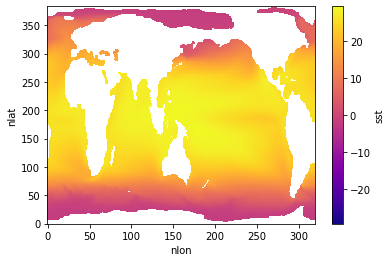

In [8]:
lgm_sst_climo.sst.plot(cmap='plasma')

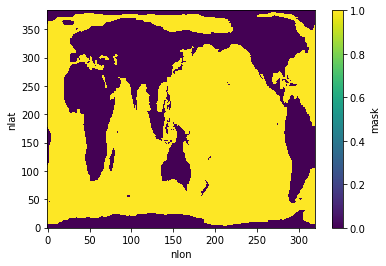

In [9]:
lgm_sst_climo.mask.plot()

In [10]:
#############
## Load SST desired grid, using old lgmDA as a ref

ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = tempds.set_coords(['lat','lon','month'])
# tempds = xr.merge([tempds.set_coords(['lat','lon','month','ens']).sst,
#                    tempds.set_coords(['lat','lon','month','ens']).ens])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = tempds.set_coords(['lat','lon','month'])
# lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

# # ## Load ICEFRAC
# dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
# holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf).set_coords(['lat','lon','month'])
# lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

In [11]:
################
# xesmf regridding 
newgrid = holo_sst_climo # desired grid
data_for_regridding = lgm_sst_climo

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
                         filename='bilinear_LGMRens_extrapID.nc',
                         reuse_weights=True)
lgm_sst_climo_hologrid_extrap = regridder(lgm_sst_climo)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


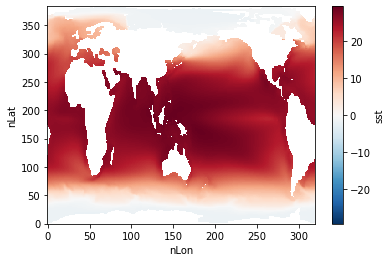

In [12]:
lgm_sst_climo_hologrid_extrap.sst.plot()

In [13]:
%%time

# for msel in range(12): ## NOT DOING MONTHLY
#     msel=0
ds = lgm_sst_climo.sst#[msel]#.sel(nLat=latslice,nLon=lonslice)
ds_holo = holo_sst_climo.sst[0] #[msel]#.sel(nLat=latslice,nLon=lonslice) #DUMMY
data_all = ds.values.ravel()

# llon, llat = np.meshgrid(ds.lon, ds.lat) ## extra lines because of regular grid
# xc = llon.ravel()[~np.isnan(data_all)]
# yc = llat.ravel()[~np.isnan(data_all)]
# all_lons = llon.ravel()
# all_lats = llat.ravel()
## IRREGULAR GRID option, switched on for LGMR
xc = ds.lon.values.ravel()[~np.isnan(data_all)]
yc = ds.lat.values.ravel()[~np.isnan(data_all)]
all_lons = ds.lon.values.ravel()
all_lats = ds.lat.values.ravel()

data = data_all[~np.isnan(data_all)] ## exclude land for the "obs"
data_coords = np.moveaxis(np.vstack([yc,xc]),-1,0)
all_coords = np.moveaxis(np.vstack([all_lats,all_lons]),-1,0)

## also get icefrac data to segment the combo
# ds_ice = lgm_ice_climo.icefrac[msel]
## find minimum latitude in NH that has sea ice;
## only will use krigging south of this latitude; not using this anymore
# icelat = np.abs(ds_ice.where(
#     (ds_ice > 0.01) & (ds_ice.lat > 0),drop=True).lat).min().values
# print('icelat ', np.round(icelat))

## determine all patch centers
latstep = 20 ## 25 for MARGO
clats1 = np.arange(-50,50+1,latstep)
#     print(clats1)
clats2 = clats1[0:-1]+latstep/2
#     print(' ',clats2)

lonstep=60 ## 90 for MARGO
clons1 = np.arange(0,360-lonstep+1,lonstep)
#     print(clons1)
clons2 = clons1[0:-1]+lonstep/2
#     print(' ',clons2)

## initialize dictionary to store kriging results and distances
krigpatch_dict = {}
alld_dict = {}

## get great circle distance around a patch
## set maximum distance for patch based on distance to diagonal patch center
choose_center_lats = clats1
choose_center_lons = clons1
choose_offset_lats = clats2
choose_offset_lons = clons2

for i,latval in enumerate(choose_center_lats):
    krigpatch_dict[latval] = {}
    alld_dict[latval] = {}

#     for j,lonval in enumerate(clons1):
    for j,lonval in enumerate(choose_center_lons):
        cpair = np.hstack([latval,lonval])[np.newaxis,:]
#             print(i, j, cpair)

        i2 = i
        j2 = j
        if i > (len(choose_offset_lats)-1): ## note this only works when doing full loop
            i2 = i-1
        if j > (len(choose_offset_lons)-1):
            j2 = j-1


        cpair_offset = np.hstack([choose_offset_lats[i2],
                                  choose_offset_lons[j2]])[np.newaxis,:]

        alld = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

        tempd = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

        maxdist = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(cpair_offset)).squeeze() * 6371 #km

#             print('maxdist = ', np.round(maxdist), 'km')

        data_inside_patch_index = np.where(tempd < maxdist)[0]
#             print('size of patch data: ',data_inside_patch_index.size)

        np.random.seed(1)
        ind = np.random.choice(data_inside_patch_index,
                               size=np.min([2000,data_inside_patch_index.size]),replace=False)

        ## set points of observations for krig
        lat = data_coords[ind][:,0]
        lon = data_coords[ind][:,1]

        OK = pyok.OrdinaryKriging(
            lon,
            lat,
            data[ind],
            variogram_model="exponential", #spherical
            verbose=False,
            enable_plotting=False,
            coordinates_type="geographic",
        )

        ## set pairs for krig based on distance from central point
        krig_ind = np.where(alld < maxdist)[0]
        krig_lon = all_lons[krig_ind]
        krig_lat = all_lats[krig_ind]

        ## old grid for krig; alternative method
        grid_lon = np.linspace(0, 359, 480)
        grid_lat = np.linspace(-89.9, 89.9, 240)


        ## the actual kriging (slow part)
        field, s2 = OK.execute('points', krig_lon, krig_lat)

        ## reshape result to be on full grid
        field_pairs = np.zeros(all_coords[:,0].shape)
        field_pairs[:] = np.nan
        field_pairs[krig_ind] = field
        field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)
        alld_da = xr.DataArray(alld.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)

        krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)
        alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)

## REPEAT PROCESS WITH LATS SWITCHED
choose_center_lats = clats2
choose_center_lons = clons2
choose_offset_lats = clats1
choose_offset_lons = clons1

for i,latval in enumerate(choose_center_lats):
    krigpatch_dict[latval] = {}
    alld_dict[latval] = {}

#     for j,lonval in enumerate(clons1):
    for j,lonval in enumerate(choose_center_lons):
        cpair = np.hstack([latval,lonval])[np.newaxis,:]
#             print(i, j, cpair)

        i2 = i
        j2 = j
        if i > (len(choose_offset_lats)-1): ## note this only works when doing full loop
            i2 = i-1
        if j > (len(choose_offset_lons)-1):
            j2 = j-1


        cpair_offset = np.hstack([choose_offset_lats[i2],
                                  choose_offset_lons[j2]])[np.newaxis,:]

        alld = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

        tempd = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

        maxdist = haversine_distances(
            np.deg2rad(cpair),np.deg2rad(cpair_offset)).squeeze() * 6371 #km

#             print('maxdist = ', np.round(maxdist), 'km')

        data_inside_patch_index = np.where(tempd < maxdist)[0]
#             print('size of patch data: ',data_inside_patch_index.size)

        np.random.seed(1)
        ind = np.random.choice(data_inside_patch_index,
                               size=np.min([2000,data_inside_patch_index.size]),replace=False)

        ## set points of observations for krig
        lat = data_coords[ind][:,0]
        lon = data_coords[ind][:,1]

        OK = pyok.OrdinaryKriging(
            lon,
            lat,
            data[ind],
            variogram_model="exponential", #spherical
            verbose=False,
            enable_plotting=False,
            coordinates_type="geographic",
        )

        ## set pairs for krig based on distance from central point
        krig_ind = np.where(alld < maxdist)[0]
        krig_lon = all_lons[krig_ind]
        krig_lat = all_lats[krig_ind]

        ## old grid for krig; alternative method
        grid_lon = np.linspace(0, 359, 480)
        grid_lat = np.linspace(-89.9, 89.9, 240)


        ## the actual kriging (slow part)
        field, s2 = OK.execute('points', krig_lon, krig_lat)

        ## reshape result to be on full grid
        field_pairs = np.zeros(all_coords[:,0].shape)
        field_pairs[:] = np.nan
        field_pairs[krig_ind] = field
        field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)
        alld_da = xr.DataArray(alld.reshape(ds.shape),
                                dims=ds.dims,coords=ds.coords)

        krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)
        alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                            dims=ds.dims,coords=ds.coords)

        ### plot result
#         proj = ccrs.Robinson()
#         fig = plt.subplots(figsize=(5,4))
#         ax = plt.subplot(projection=proj)
#         plt.pcolormesh(field_da.lon,field_da.lat,field_da,
#                        transform = ccrs.PlateCarree(),
#                        cmap='plasma')
#         plt.title(str(i) + ', ' + str(j) + ' ' + str(cpair.squeeze()))        
#         plt.show()

#         fig = plt.subplots(figsize=(5,4))
#         ax = plt.subplot(projection=proj)
#         plt.pcolormesh(field_da.lon,field_da.lat,1/alld_da,
#                        transform = ccrs.PlateCarree(),
#                        cmap='Reds',vmax=1/1000)
#         plt.show()

### Addition for Bering Straight
addl_cpairs = 0
addl_cpairs +=1
latval = 66
lonval = 192
krigpatch_dict[latval] = {}
alld_dict[latval] = {}


cpair = np.hstack([latval,lonval])[np.newaxis,:]
print(i, j, cpair)

alld = haversine_distances(
    np.deg2rad(cpair),np.deg2rad(all_coords)).squeeze() * 6371 #km

tempd = haversine_distances(
    np.deg2rad(cpair),np.deg2rad(data_coords)).squeeze() * 6371 #km

maxdist = 3000 # 4500 for MARGO
# print('maxdist = ', np.round(maxdist), 'km')

data_inside_patch_index = np.where(tempd < maxdist)[0]
# print('size of patch data: ',data_inside_patch_index.size)

np.random.seed(1)
ind = np.random.choice(data_inside_patch_index,
                       size=np.min([1200,data_inside_patch_index.size]),replace=False)

## set points of observations for krig
lat = data_coords[ind][:,0]
lon = data_coords[ind][:,1]

OK = pyok.OrdinaryKriging(
    lon,
    lat,
    data[ind],
    variogram_model="exponential", #spherical
    verbose=False,
    enable_plotting=False,
    coordinates_type="geographic",
)

## set pairs for krig based on distance from central point
krig_ind = np.where(alld < maxdist)[0]
krig_lon = all_lons[krig_ind]
krig_lat = all_lats[krig_ind]

## old grid for krig; alternative method
grid_lon = np.linspace(0, 359, 480)
grid_lat = np.linspace(-89.9, 89.9, 240)


## the actual kriging (slow part)
field, s2 = OK.execute('points', krig_lon, krig_lat)

## reshape result to be on full grid
field_pairs = np.zeros(all_coords[:,0].shape)
field_pairs[:] = np.nan
field_pairs[krig_ind] = field
field_da = xr.DataArray(field_pairs.reshape(ds.shape),
                        dims=ds.dims,coords=ds.coords)
alld_da = xr.DataArray(alld.reshape(ds.shape),
                        dims=ds.dims,coords=ds.coords)

krigpatch_dict[latval][lonval] = xr.DataArray(field_pairs.reshape(ds.shape),
                    dims=ds.dims,coords=ds.coords)
alld_dict[latval][lonval] = xr.DataArray(alld.reshape(ds.shape),
                    dims=ds.dims,coords=ds.coords)

weights = np.zeros(np.append(ds.shape,
                         len(clats1)*len(clats1) + len(clats2)*len(clats2) + addl_cpairs))

l = 0
for i,val in alld_dict.items():
    for j,val2 in val.items():
        weights[:,:,l] = 1/(val2+1) * (krigpatch_dict[i][j]/krigpatch_dict[i][j])
        l += 1

wsum = np.nansum(weights,axis=2)
wsum[wsum == 0] = np.nan

frank_weighted = np.zeros(ds.shape)

l = 0
for i,val in krigpatch_dict.items():
    for j,da in val.items():
        frank_weighted += np.nan_to_num(da * weights[:,:,l])
        l += 1

frank_weighted = frank_weighted / wsum

ocean_ind = ds_holo/ds_holo 
frank_mask = ocean_ind * frank_weighted

# create a unique mask based on where kriging is necessary vs. extrap
# this decision is based on inspection
# SKIP THIS STEP FOR MARGO
temp_mask = frank_mask.where((frank_mask.nLon > 0) & 
             (frank_mask.nLat < 280) & 
             (frank_mask.nLon < 40) | 
             (frank_mask.nLon >= 40) & 
             (frank_mask.nLon < 140) & 
             (frank_mask.nLat < 278) | 
             (frank_mask.nLon >= 140) & 
             (frank_mask.lat < 69) & 
             (frank_mask.nLon < 210) | 
             (frank_mask.nLon >= 210) & 
             (frank_mask.nLat < 325) & 
             (frank_mask.nLon < 293) | 
             (frank_mask.nLon >= 293) & 
             (frank_mask.lat < 58))
temp_mask = temp_mask.where(temp_mask.nLat > 40)

## combine the kriging with the lgm original
krig_wlgm = xr.where(np.isnan(ds) & ~np.isnan(temp_mask.values),frank_mask.values,ds)

## regrid this combo onto holo grid with extrapolation to fill in high lats
newgrid = holo_sst_climo.isel(nmonth=1) # desired grid
data_for_regridding = krig_wlgm.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,extrap_num_src_pnts=64,
                         extrap_method='inverse_dist',
                         filename='bilinear_krigwlgm_to_holo_per_extrapID64.nc',
                         reuse_weights=True)

merged = regridder(krig_wlgm).to_dataset()
merged['mask'] = xr.where(
    ~np.isnan(merged.sst),1,0)

## save files
# mstring = str(frank_mask.month.values).zfill(2)
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# fname_krig = 'LGMR_lgmNorm_SST_monthly_climo_krigged_' + mstring + '.nc'
fname_merged = setname + '_merged.nc'

# frank_mask.to_netcdf(savepath + fname_krig)
# merged.to_netcdf(savepath + fname_merged)
print('finished saving mem ' + memstring)
print(datetime.datetime.now() - begin_time)

4 4 [[ 66 192]]
maxdist =  3000 km
size of patch data:  3984
finished saving mem 01
0:05:22.994023
CPU times: user 9min 21s, sys: 1min 25s, total: 10min 46s
Wall time: 5min 6s


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [38]:
!ls /home/disk/sipn/vcooper/nobackup/lgm/infilled/

amrhein_lgm_SST_annual_krigged_anoann.nc
amrhein_lgm_SST_annual_merged_anoann.nc
archive
ens
lgmDA_hol_ICEFRAC_monthly_climo_merged_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_01.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_01_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_02.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_02_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_03.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_03_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_04.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_04_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_05.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_05_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_06.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_06_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_07.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_07_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_08.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_08_v2.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_09.nc
lgmDA_lgm_ICEFRAC_monthly_climo_merged_09_v2.nc
lgmDA_lgm_ICEFRAC_monthly

In [ ]:
# ## save files
# mstring = str(frank_mask.month.values).zfill(2)
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
# fname_krig = 'LGMR_holo_SST_monthly_climo_krigged_' + mstring + '.nc'
# fname_merged = 'LGMR_holo_SST_monthly_climo_merged_' + mstring + '.nc'

# frank_mask.to_netcdf(savepath + fname_krig)
# merged.to_netcdf(savepath + fname_merged)
# print('finished saving month ' + mstring)

## Quick results check

In [18]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [6]:
spath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/ensLGMR/'
fname = 'LGMR_SST_lgm_allens.nc'
allens_lgm = xr.open_dataset(spath + fname)

fname = 'LGMR_SST_holo_allens.nc'
allens_holo = xr.open_dataset(spath + fname)

In [12]:
allens_lgm.sst

<xarray.DataArray 'sst' (nens: 50, nLat: 384, nLon: 320)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
    lon      (nLat, nLon) float64 ...
    lat      (nLat, nLon) float64 ...
Dimensions without coordinates: nens, nLat, nLon
Attributes:
    regrid_method:  bilinear

In [14]:
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = allens_lgm
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
#                          filename='bilinear_again.nc',
                         reuse_weights=False)

allens_lgm_regrid = regridder(allens_lgm)
allens_holo_regrid = regridder(allens_holo)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


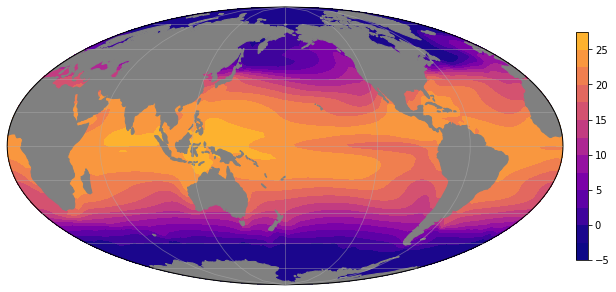

In [20]:
## input data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = allens_lgm_regrid.sst[0]#.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = 'plasma',vmin=-2,vmax=32,levels=12,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('Input ' + dsname)
plt.show()

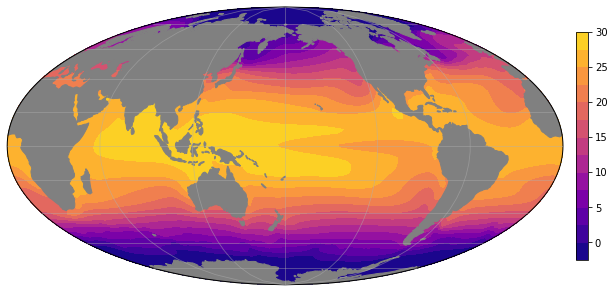

In [21]:
## input data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = allens_holo_regrid.sst[0]#.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = 'plasma',vmin=-2,vmax=32,levels=12,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('Input ' + dsname)
plt.show()

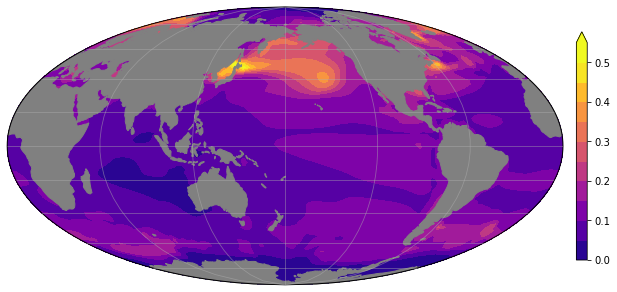

In [27]:
## input data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = allens_holo_regrid.sst.std(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = 'plasma',vmin=0,vmax=0.5,levels=11,extend='max',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title('Input ' + dsname)
plt.show()

In [28]:
spath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/ensLGMR/'
fname = 'LGMR_SST_lgm_allens_regrid.nc'
allens_lgm_regrid.to_netcdf(spath + fname)

fname = 'LGMR_SST_holo_allens_regrid.nc'
allens_holo_regrid.to_netcdf(spath + fname)